In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from edpyt.shared import params
from edpyt.espace import build_espace, screen_espace
from edpyt.gf2_lanczos import build_gf2_lanczos

new_path = '/capstor/scratch/cscs/ajayaraj/qtpyt-tests/pentadienyl'
os.chdir(new_path)

/users/ajayaraj/miniconda3/envs/qtpyt/lib/python3.9/site-packages/numba/cpython/hashing.py:524: UserWarning: FNV hashing is not implemented in Numba. See PEP 456 https://www.python.org/dev/peps/pep-0456/ for rationale over not using FNV. Numba will continue to work, but hashes for built in types will be computed using siphash24. This will permit e.g. dictionaries to continue to behave as expected, however anything relying on the value of the hash opposed to hash as a derived property is likely to not work as expected.
  warnings.warn(msg)


In [ ]:
class Sigma:
    def __init__(self, gf, H_eff, eta=1e-5):
        self.gf = gf
        self.eta = eta
        self.H_eff = H_eff

    def retarded(self, energy):
        energies = np.atleast_1d(energy)
        g = self.gf(energies, self.eta)
        sigma = np.empty((energies.size, self.gf.n, self.gf.n), complex)
        for e, energy in enumerate(energies):
            sigma[e] = energy - (self.H_eff) - np.linalg.inv(g[..., e])
        return sigma

In [ ]:
# === Load inputs ===
input_folder = "output/lowdin"
output_folder = "output/lowdin/beta_1000/ed"
os.makedirs(output_folder, exist_ok=True)

H_eff = np.load(f"{input_folder}/effective_hamiltonian.npy")
occupancy_goal = np.load(f"{input_folder}/beta_1000/occupancies.npy")
V = np.loadtxt(f"{input_folder}/U_matrix.txt")

# === Parameters ===
nimp = H_eff.shape[0]
eta = 3e-2
beta = 1000

# === Initial double counting ===
DC0 = np.diag(V.diagonal() * (occupancy_goal - 0.5))
neig = np.ones((nimp + 1) * (nimp + 1), int) * 6

params['z'] = occupancy_goal

In [ ]:
plot_counter = 0
fig_dir = os.path.join(output_folder, "figures")
os.makedirs(fig_dir, exist_ok=True)
energies_plot = np.arange(-20, 18, 0.1)


In [5]:
espace, egs = build_espace(H_eff - DC0, V, neig_sector=neig)
screen_espace(espace, egs, beta)

gf = build_gf2_lanczos(H_eff - DC0, V, espace, beta, egs)
sigma = Sigma(gf, H_eff, eta=eta)
sigma_ret = sigma.retarded(energies_plot)
sigma_ret_trace = np.trace(sigma_ret, axis1=1, axis2=2)

# plt.plot(energies_plot, sigma_ret_trace.real, label="Real part")
# plt.plot(energies_plot, sigma_ret_trace.imag, label="Imaginary part")
# plt.xlabel("Energy")
# plt.ylabel("Sigma")
# plt.xlim(-20, -18)
# plt.ylim(-10,20)
# plt.legend()
# plt.show()

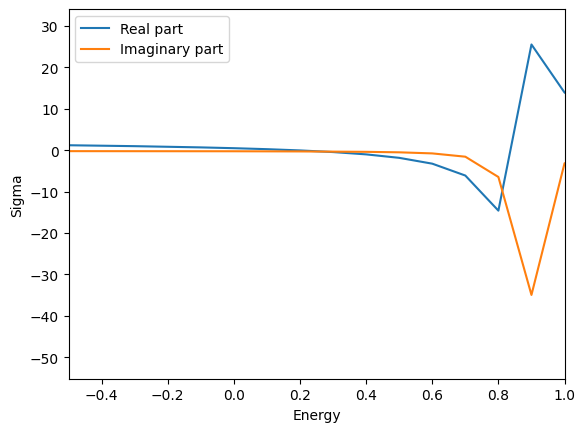

In [6]:
plt.plot(energies_plot, sigma_ret_trace.real, label="Real part")
plt.plot(energies_plot, sigma_ret_trace.imag, label="Imaginary part")
plt.xlabel("Energy")
plt.ylabel("Sigma")
plt.xlim(-0.5, 1)
# plt.ylim(-10,20)
plt.legend()
plt.show()

In [7]:
energy = [-10000.0]
sig_cost = sigma.retarded(energy)
sig_real_diag = sig_cost.real.diagonal(axis1=1, axis2=2)
print(sig_real_diag)
# residual = np.mean(sig_real_diag, axis=1)
# res_norm = np.linalg.norm(residual)
# np.sum(sig_real_diag,axis=1)
# sig_real_diag.shape


[[-1.06737965  0.67095244  0.718109    0.94747418  0.73800953  0.92566272
  -0.97249935]]


In [ ]:
energy = [-50.0, -60, -70, -80, -100]
sig_cost = sigma.retarded(energy)
sig_real_diag = sig_cost.real.diagonal(axis1=1, axis2=2)
# residual = np.mean(sig_real_diag, axis=1)
# res_norm = np.linalg.norm(residual)
np.sum(sig_real_diag,axis=1)
# sig_real_diag.shape

array([1.6744167 , 1.72634912, 1.76203467, 1.78816452])

In [13]:
energy = [50.0]
sig_cost = sigma.retarded(energy)
sig_real_diag = sig_cost.real.diagonal(axis1=1, axis2=2)
residual = np.mean(sig_real_diag, axis=0)
res_norm = np.linalg.norm(residual)
np.sum(sig_real_diag)


2.2422149754689826

In [ ]:
energy = [-1000.0]
sig_cost = sigma.retarded(energy)
sig_real_diag = sig_cost.real.diagonal(axis1=1, axis2=2)
residual = np.mean(sig_real_diag, axis=0)
res_norm = np.linalg.norm(residual)
np.sum(sig_real_diag)


### Broyden mixing

In [41]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import broyden1

class Converged(Exception):
    pass

# Penalty tuning
penalty_weight = 1.0      # Less aggressive than before
delta_order = 0.01        # Minimum margin for ordering (eV)
dc_diag_clip_bounds = (2.0, 10.0)  # Prevent unphysical values

# Precompute reference ratio structure
dc0_diag = DC0.diagonal()
target_ratios = dc0_diag / np.max(dc0_diag)

plot_counter = 0
fig_dir = os.path.join(output_folder, "figures")
os.makedirs(fig_dir, exist_ok=True)
energies_plot = np.arange(-20, 20.1, 0.1)
def residual_function(dc_diag):
    global plot_counter

    # Clip unphysical values
    dc_diag = np.clip(dc_diag, *dc_diag_clip_bounds)

    # Main physics calculation
    DC = np.diag(dc_diag)
    espace, egs = build_espace(H_eff - DC, V, neig_sector=neig)
    screen_espace(espace, egs, beta)
    gf = build_gf2_lanczos(H_eff - DC, V, espace, beta, egs)
    sigma = Sigma(gf, H_eff, eta=eta)

    # Get physical residual from Σ at large negative frequency
    energies = np.array([-10000.0])
    sig_cost = sigma.retarded(energies)  # (n_energies, nimp, nimp)
    sig_real_diag = sig_cost.real.diagonal(axis1=1, axis2=2)
    residual = np.mean(sig_real_diag, axis=0)

    # -----------------------------------
    # Penalty terms for structure control
    # -----------------------------------

    # 1. Ordering penalty
    order_penalty = np.zeros_like(residual)
    others = np.delete(dc_diag, [0, 6])
    if dc_diag[0] < np.max(others) + delta_order:
        order_penalty[0] += penalty_weight * (np.max(others) + delta_order - dc_diag[0])
    if dc_diag[6] < np.max(np.delete(dc_diag, [0])) + delta_order:
        order_penalty[6] += penalty_weight * (np.max(np.delete(dc_diag, [0])) + delta_order - dc_diag[6])

    # 2. Ratio penalty (safe log scale)
    dc_diag_max = np.max(dc_diag) if np.max(dc_diag) > 1e-8 else 1.0
    current_ratios = dc_diag / dc_diag_max
    ratio_penalty = penalty_weight * (np.log1p(current_ratios) - np.log1p(target_ratios))

    # Combine all into total residual
    total_residual = residual + order_penalty + ratio_penalty

    # -----------------------------------
    # Logging and plotting
    # -----------------------------------
    residual_norm = np.linalg.norm(total_residual)
    print(f"[Broyden] Residual norm: {residual_norm:.6e}, DC_diag: {dc_diag}")
    print(f"Penalty | Order: {np.linalg.norm(order_penalty):.3e}, Ratio: {np.linalg.norm(ratio_penalty):.3e}")

    # Plot Σ trace
    sig_plot = sigma.retarded(energies_plot)
    trace_real = np.trace(sig_plot.real, axis1=1, axis2=2)
    trace_imag = np.trace(sig_plot.imag, axis1=1, axis2=2)

    plt.figure(figsize=(6, 4))
    plt.plot(energies_plot, trace_real, label="Re Tr Σ(ω)", linestyle="-")
    plt.plot(energies_plot, trace_imag, label="Im Tr Σ(ω)", linestyle="--")
    plt.xlabel("Energy (eV)")
    plt.ylabel("Tr Σ(ω)")
    plt.title(f"Σ Trace – Eval {plot_counter}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    fig_path = os.path.join(fig_dir, f"sigma_trace_eval_{plot_counter:03d}.png")
    plt.savefig(fig_path, dpi=100)
    plt.close()
    plot_counter += 1

    return total_residual


# Initial guess
x0 = dc0_diag.copy()

dc_diag_optimized = broyden1(
    residual_function,
    x0,
    f_tol=1e-3,
    maxiter=50,
    verbose=True,
)


[Broyden] Residual norm: 2.300652e+00, DC_diag: [5.46515887 2.         2.52035611 2.22202704 2.7152016  2.12250731
 5.90703705]
Penalty | Order: 1.000e-02, Ratio: 2.676e-03
[Broyden] Residual norm: 2.579716e+00, DC_diag: [3.24622832 3.33869596 4.01669982 4.18971364 4.24655683 4.04640243
 3.89931972]
Penalty | Order: 1.072e+00, Ratio: 7.455e-01
[Broyden] Residual norm: 7.716108e-01, DC_diag: [4.58274611 2.51963559 3.11541429 3.00452642 3.32418299 2.88759192
 5.10861846]
Penalty | Order: 1.000e-02, Ratio: 2.879e-01
0:  |F(x)| = 0.378853; step 0.397675
[Broyden] Residual norm: 3.962694e-01, DC_diag: [4.54307932 2.89783115 3.66346204 3.61002152 3.96971804 3.27286948
 5.16436948]
Penalty | Order: 1.000e-02, Ratio: 4.157e-01
1:  |F(x)| = 0.239308; step 1
[Broyden] Residual norm: 1.954572e-01, DC_diag: [4.26483954 2.78273423 3.47711185 3.48488478 3.70898035 3.23192589
 4.82784267]
Penalty | Order: 1.000e-02, Ratio: 4.386e-01
2:  |F(x)| = 0.104433; step 1
[Broyden] Residual norm: 1.092804e-02,

DC0 [5.46515887 1.97886514 2.52035611 2.22202704 2.7152016  2.12250731
 5.90703705]
DC [4.34588258 2.82913235 3.5504973  3.52856523 3.80738195 3.25745124
 4.93010224]


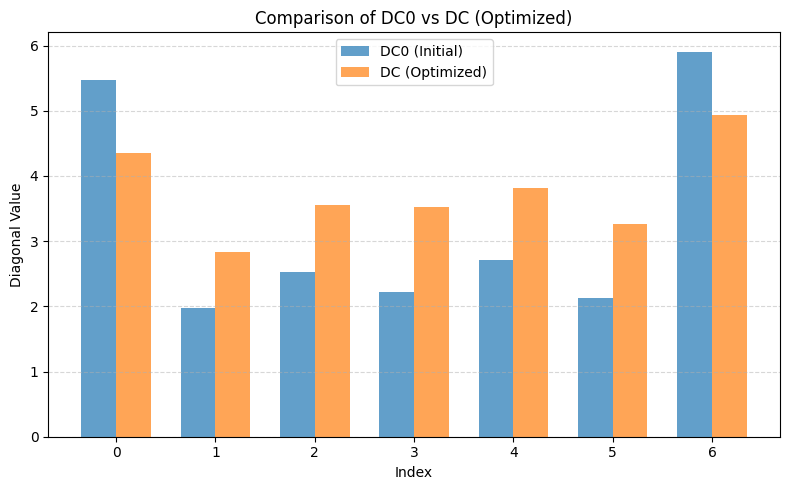

In [42]:
DC = np.diag(dc_diag_optimized)
print("DC0", np.diag(DC0))
print("DC", np.diag(DC))

# Indices for each element
indices = np.arange(len(dc0_diag))

# Width of bars
bar_width = 0.35

# Create the plot
plt.figure(figsize=(8, 5))
plt.bar(indices - bar_width/2, dc0_diag, width=bar_width, label='DC0 (Initial)', alpha=0.7)
plt.bar(indices + bar_width/2, dc_diag_optimized, width=bar_width, label='DC (Optimized)', alpha=0.7)

# Labels and legend
plt.xlabel('Index')
plt.ylabel('Diagonal Value')
plt.title('Comparison of DC0 vs DC (Optimized)')
plt.xticks(indices)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [13]:
de = 0.01
energies = np.arange(-3, 3 + de / 2.0, de).round(7)
eta = 1e-3

espace, egs = build_espace(H_eff - DC, V, neig_sector=neig)
screen_espace(espace, egs, beta)

gf = build_gf2_lanczos(H_eff - DC, V, espace, beta, egs)
sigma = Sigma(gf, H_eff, eta=eta)
sigma_ret = sigma.retarded(energies)
sigma_ret_trace = np.trace(sigma_ret, axis1=1, axis2=2)


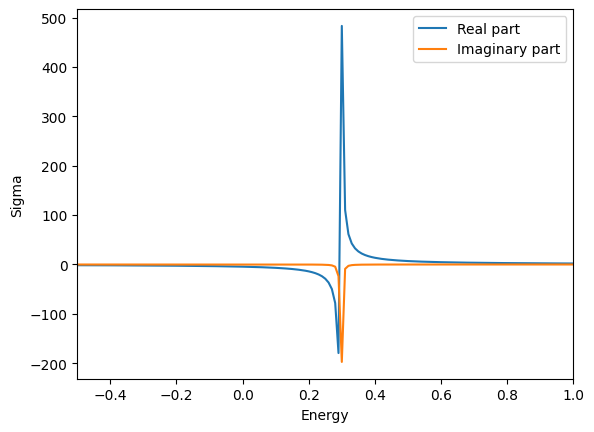

In [14]:
plt.plot(energies, sigma_ret_trace.real, label="Real part")
plt.plot(energies, sigma_ret_trace.imag, label="Imaginary part")
plt.xlabel("Energy")
plt.ylabel("Sigma")
plt.xlim(-0.5, 1)
# plt.ylim(-10,20)
plt.legend()
plt.show()

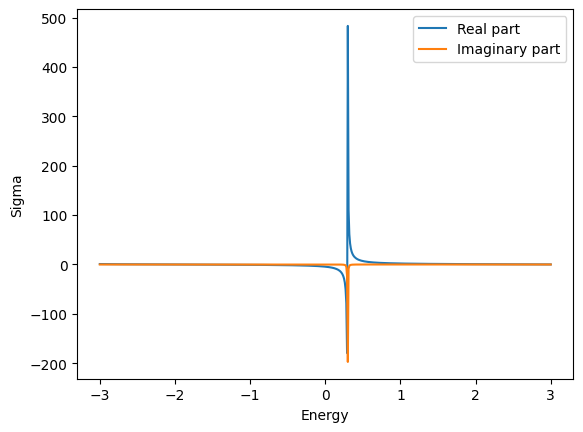

In [ ]:
DC = np.load("./output/lowdin/beta_1000/ed/ed_dcc_diag_test.npy")
DC = np.diag(DC)
espace, egs = build_espace(H_eff - DC, V, neig_sector=neig)
screen_espace(espace, egs, beta)

gf = build_gf2_lanczos(H_eff - DC, V, espace, beta, egs)


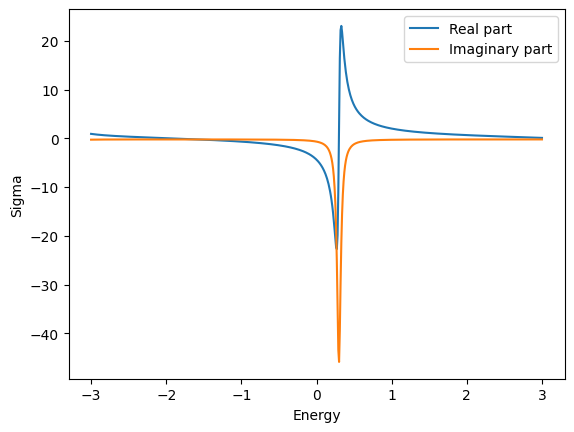

In [17]:
sigma = Sigma(gf, H_eff, eta=3e-2)
sigma_ret = sigma.retarded(energies)
sigma_ret_trace = np.trace(sigma_ret, axis1=1, axis2=2)

plt.plot(energies, sigma_ret_trace.real, label="Real part")
plt.plot(energies, sigma_ret_trace.imag, label="Imaginary part")
plt.xlabel("Energy")
plt.ylabel("Sigma")
# plt.xlim(-0.5, 1)
# plt.ylim(-10,20)
plt.legend()

In [28]:
sig_ref = np.load("./reference/sigma_ed_diag.npy")
sig_trace = np.sum(sig_ref, axis=0)
energies_ref = np.linspace(-0.5,1, 2000)


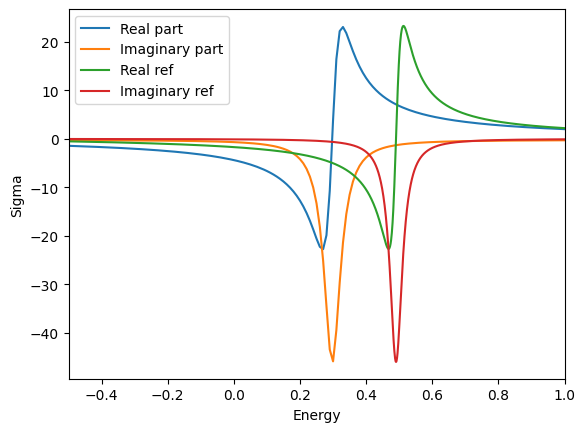

In [29]:
plt.plot(energies, sigma_ret_trace.real, label="Real part")
plt.plot(energies, sigma_ret_trace.imag, label="Imaginary part")
plt.plot(energies_ref,sig_trace.real, label="Real ref")
plt.plot(energies_ref,sig_trace.imag, label="Imaginary ref")
plt.plot
plt.xlabel("Energy")
plt.ylabel("Sigma")
plt.xlim(-0.5, 1)
# plt.ylim(-10,20)
plt.legend()